# <div align=center><b>Working with Zarr and Xarray</b></div>
Most Pythonistas are familair with Pandas and NumPy (and maybe Torch) for handling their data and might be less familiar with Zarr and Xarray. This tutorial is meant to highlight what you need to know about Zarr and Xarray to work with SeqData. More comprehensive tutorials can be found at ...

## Why use Xarray?

Genomics data is multidimensional and complex, and while Pandas is great for 2D data and NumPy can handle n-dimensional arrays, Xarray is specifically designed to handle n-dimensional data with labeled dimensions and coordinates. We believe this leads to a more intuitive, more concise, and less error-prone developer experience. The good thing about Xarray is that it built with a Pythonic API very similar to Pandas and NumPy and can easily convert between these libraries.

In [2]:
import numpy as np
import pandas as pd
import xarray as xr

Xarray has two core data structures that are fundamentally N-dimensional. The first are `DataArrays` which are simply labeled, N-dimensional array. It is an N-D generalization of a pandas.Series. Data arrays work very similarly to numpy ndarrays:

In [8]:
data = xr.DataArray(np.random.randn(2, 3), dims=("x", "y"), coords={"x": [10, 20]})
data

<xarray.DataArray (x: 2, y: 3)>
array([[ 1.75540388,  0.9894944 ,  0.63997156],
       [ 0.25238191, -0.08634175, -0.10940408]])
Coordinates:
  * x        (x) int64 10 20
Dimensions without coordinates: y

The second is a multi-dimensional, in-memory array database called a Dataset. It is a dict-like container of DataArray objects aligned along any number of shared dimensions, and serves a similar purpose in xarray to the pandas.DataFrame.

In [9]:
ds = xr.Dataset(dict(foo=data, bar=("x", [1, 2]), baz=np.pi))
ds

<xarray.Dataset>
Dimensions:  (x: 2, y: 3)
Coordinates:
  * x        (x) int64 10 20
Dimensions without coordinates: y
Data variables:
    foo      (x, y) float64 1.755 0.9895 0.64 0.2524 -0.08634 -0.1094
    bar      (x) int64 1 2
    baz      float64 3.142



The power of the dataset over a plain dictionary is that, in addition to pulling out arrays by name, it is possible to select or combine data along a dimension across all arrays simultaneously. Like a DataFrame, datasets facilitate array operations with heterogeneous data – the difference is that the arrays in a dataset can have not only different data types, but also different numbers of dimensions.



In [10]:
ds["foo"]

<xarray.DataArray 'foo' (x: 2, y: 3)>
array([[ 1.75540388,  0.9894944 ,  0.63997156],
       [ 0.25238191, -0.08634175, -0.10940408]])
Coordinates:
  * x        (x) int64 10 20
Dimensions without coordinates: y

Dot operators


In [11]:
ds.foo

<xarray.DataArray 'foo' (x: 2, y: 3)>
array([[ 1.75540388,  0.9894944 ,  0.63997156],
       [ 0.25238191, -0.08634175, -0.10940408]])
Coordinates:
  * x        (x) int64 10 20
Dimensions without coordinates: y

You only need to do the tedious work of adding metadata once, not every time you save a file.

## Working with Xarray

### Indexing
https://docs.xarray.dev/en/stable/user-guide/indexing.html

In total, xarray supports four different kinds of indexing, as described below and summarized in this table:

| Dimension lookup | Index lookup | `DataArray` syntax            | `Dataset` syntax             |
|------------------|--------------|-------------------------------|------------------------------|
| Positional       | By integer   | `da[:, 0]`                    | *not available*              |
| Positional       | By label     | `da.loc[:, 'IA']`             | *not available*              |
| By name          | By integer   | `da.isel(space=0)` or <br>    | `ds.isel(space=0)` or <br>   |
|                  |              | `da[dict(space=0)]`           | `ds[dict(space=0)]`          |
| By name          | By label     | `da.sel(space='IA')` or <br>  | `ds.sel(space='IA')` or <br> |
|                  |              | `da.loc[dict(space='IA')]`    | `ds.loc[dict(space='IA')]`   |

More advanced indexing is also possible for all the methods by supplying `xarray.DataArray` objects as indexer. See [vectorized_indexing](#vectorized_indexing) for the details.


In [ ]:
da = xr.DataArray(
    np.random.rand(4, 3),
    [
        ("time", pd.date_range("2000-01-01", periods=4)),
        ("space", ["IA", "IL", "IN"]),
    ],
)
da

<xarray.DataArray (time: 4, space: 3)>
array([[0.2353759 , 0.19600237, 0.52445027],
       [0.35011504, 0.5201031 , 0.69720723],
       [0.36596133, 0.23805607, 0.61743269],
       [0.86655783, 0.32540117, 0.55893203]])
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-01-02 2000-01-03 2000-01-04
  * space    (space) <U2 'IA' 'IL' 'IN'

Indexing a DataArray directly works (mostly) just like it does for numpy arrays, except that the returned object is always another DataArray:

In [ ]:
da[:2]

<xarray.DataArray (time: 2, space: 3)>
array([[0.2353759 , 0.19600237, 0.52445027],
       [0.35011504, 0.5201031 , 0.69720723]])
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-01-02
  * space    (space) <U2 'IA' 'IL' 'IN'

In [ ]:
da[0, 0]

<xarray.DataArray ()>
array(0.2353759)
Coordinates:
    time     datetime64[ns] 2000-01-01
    space    <U2 'IA'

Xarray also supports label-based indexing, just like pandas.

In [ ]:
da.loc["2000-01-01":"2000-01-02", "IA"]

With the dimension names, we do not have to rely on dimension order and can use them explicitly to slice data. There are two ways to do this:

In [24]:
# index by integer array indices
da.isel(space=0, time=slice(None, 2))

<xarray.DataArray (time: 2)>
array([0.2353759 , 0.35011504])
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-01-02
    space    <U2 'IA'

In [ ]:
# index by dimension coordinate labels
da.sel(time=slice("2000-01-01", "2000-01-02"))

In [ ]:

da[dict(space=0, time=slice(None, 2))]

We can also use these methods to index all variables in a dataset simultaneously, returning a new dataset:

In [25]:
da = xr.DataArray(
    np.random.rand(4, 3),
    [
        ("time", pd.date_range("2000-01-01", periods=4)),
        ("space", ["IA", "IL", "IN"]),
    ],
)

In [26]:
ds = da.to_dataset(name="foo")

In [27]:
ds

<xarray.Dataset>
Dimensions:  (time: 4, space: 3)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-01-02 2000-01-03 2000-01-04
  * space    (space) <U2 'IA' 'IL' 'IN'
Data variables:
    foo      (time, space) float64 0.355 0.5195 0.8761 ... 0.1318 0.3912 0.3675

In [28]:
ds.isel(space=[0], time=[0])

<xarray.Dataset>
Dimensions:  (time: 1, space: 1)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01
  * space    (space) <U2 'IA'
Data variables:
    foo      (time, space) float64 0.355

In [29]:
ds.sel(time="2000-01-01")

<xarray.Dataset>
Dimensions:  (space: 3)
Coordinates:
    time     datetime64[ns] 2000-01-01
  * space    (space) <U2 'IA' 'IL' 'IN'
Data variables:
    foo      (space) float64 0.355 0.5195 0.8761

Positional indexing on a dataset is not supported because the ordering of dimensions in a dataset is somewhat ambiguous (it can vary between different arrays). However, you can do normal indexing with dimension names:

In [30]:
ds[dict(space=[0], time=[0])]

<xarray.Dataset>
Dimensions:  (time: 1, space: 1)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01
  * space    (space) <U2 'IA'
Data variables:
    foo      (time, space) float64 0.355

In [ ]:
series = data.to_series()
series

In [15]:
air.isel?

Signature:
air.isel(
    indexers: 'Mapping[Any, Any] | None' = None,
    drop: 'bool' = False,
    missing_dims: 'ErrorOptionsWithWarn' = 'raise',
    **indexers_kwargs: 'Any',
) -> 'T_DataArray'
Docstring:
Return a new DataArray whose data is given by selecting indexes
along the specified dimension(s).

Parameters
----------
indexers : dict, optional
    A dict with keys matching dimensions and values given
    by integers, slice objects or arrays.
    indexer can be a integer, slice, array-like or DataArray.
    If DataArrays are passed as indexers, xarray-style indexing will be
    carried out. See :ref:`indexing` for the details.
    One of indexers or indexers_kwargs must be provided.
drop : bool, default: False
    If ``drop=True``, drop coordinates variables indexed by integers
    instead of making them scalar.
missing_dims : {"raise", "warn", "ignore"}, default: "raise"
    What to do if dimensions that should be selected from are not present in the
    DataArray:
    - "rais

In [14]:
air1d

<xarray.DataArray 'air' (time: 2920)>
array([7.6400146, 7.850006 , 8.049988 , ..., 9.339996 , 9.339996 ,
       9.540009 ], dtype=float32)
Coordinates:
    lat      float32 50.0
    lon      float32 225.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         deg C
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

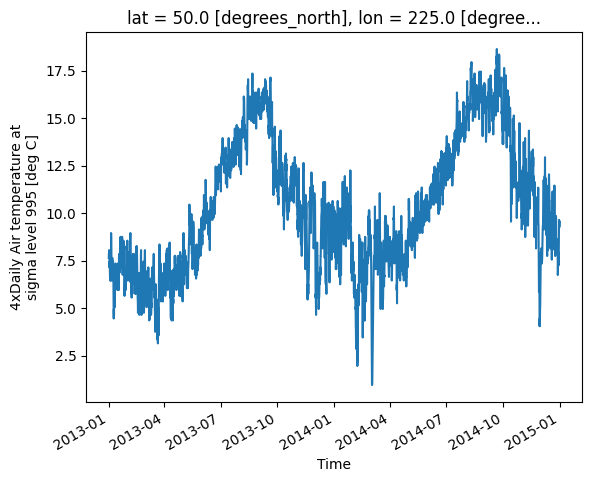

In [13]:
airtemps = xr.tutorial.open_dataset("air_temperature")
airtemps

# Convert to celsius
air = airtemps.air - 273.15

# copy attributes to get nice figure labels and change Kelvin to Celsius
air.attrs = airtemps.air.attrs

air.attrs["units"] = "deg C"

air1d = air.isel(lat=10, lon=10)
air1d.plot()

For more...https://docs.xarray.dev/en/stable/user-guide/plotting.html

## Reading and writing to Zarr stores: The minimum you need to know about Zarr

In [ ]:
Zarr is a Python package that provides an implementation of chunked, compressed, N-dimensional arrays. Zarr has the ability to store arrays in a range of ways, including in memory, in files, and in cloud-based object storage such as Amazon S3 and Google Cloud Storage. Xarray’s Zarr backend allows xarray to leverage these capabilities, including the ability to store and analyze datasets far too large fit onto disk (particularly in combination with dask).

In [ ]:
Xarray can’t open just any zarr dataset, because xarray requires special metadata (attributes) describing the dataset dimensions and coordinates.

In [ ]:
sd.to_zarr is a wrapper Dataset.to_zarr() 

In [ ]:
Xarray supports several ways of incrementally writing variables to a Zarr store. These options are useful for scenarios when it is infeasible or undesirable to write your entire dataset at once.

Use mode='a' to add or overwrite entire variables,

Use append_dim to resize and append to existing variables, and

Use region to write to limited regions of existing arrays.

In [ ]:
- Use “a” mode for appending
    - Ideally, you remove everything that exists on disk when you loaded so you are only just appending what you have added
    - But using “a” without doing this is fine, will just take longer and should probably be avoided on very large datasets where lots of data exists already in the zarr on disk
- Do not use “w” mode for data that is not loaded into memory
    - It will delete everything on disk and then try to write dask arrays without access to that data anymore
    - Gives corrupted data on the next load
- Use “r+” when you are haven’t modifed metadata at all, very simple operations

In [ ]:
To store variable length strings, convert them to object arrays first with dtype=object.

To read back a zarr dataset that has been created this way, we use the open_zarr() method:



In [ ]:
https://docs.xarray.dev/en/stable/user-guide/io.html#zarr

## How best to take advantage of XArray’s lazy operations

Xarray integrates with Dask to support parallel computations and streaming computation on datasets that don’t fit into memory. Currently, Dask is an entirely optional feature for xarray. However, the benefits of using Dask are sufficiently strong that Dask may become a required dependency in a future version of xarray.

In [ ]:
Dask divides arrays into many small pieces, called chunks, each of which is presumed to be small enough to fit into memory.

Unlike NumPy, which has eager evaluation, operations on Dask arrays are lazy. Operations queue up a series of tasks mapped over blocks, and no computation is performed until you actually ask values to be computed (e.g., to print results to your screen or write to disk). At that point, data is loaded into memory and computation proceeds in a streaming fashion, block-by-block.

The actual computation is controlled by a multi-processing or thread pool, which allows Dask to take full advantage of multiple processors available on most modern computers.

For more details, read the Dask documentation. Note that xarray only makes use of dask.array and dask.delayed.

In [ ]:
Nearly all existing xarray methods (including those for indexing, computation, concatenating and grouped operations) have been extended to work automatically with Dask arrays. When you load data as a Dask array in an xarray data structure, almost all xarray operations will keep it as a Dask array; when this is not possible, they will raise an exception rather than unexpectedly loading data into memory. Converting a Dask array into memory generally requires an explicit conversion step. One notable exception is indexing operations: to enable label based indexing, xarray will automatically load coordinate labels into memory.

In [ ]:
The easiest way to convert an xarray data structure from lazy Dask arrays into eager, in-memory NumPy arrays is to use the load() method:

ds.load()
Out[10]: 
<xarray.Dataset> Size: 8MB
Dimensions:      (time: 30, latitude: 180, longitude: 180)
Coordinates:
  * time         (time) datetime64[ns] 240B 2015-01-01 2015-01-02 ... 2015-01-30
  * longitude    (longitude) int64 1kB 0 1 2 3 4 5 6 ... 174 175 176 177 178 179
  * latitude     (latitude) float64 1kB 89.5 88.5 87.5 ... -87.5 -88.5 -89.5
Data variables:
    temperature  (time, latitude, longitude) float64 8MB 0.4691 ... -0.2467
You can also access values, which will always be a NumPy array:

ds.temperature.values
Out[11]: 
array([[[  4.691e-01,  -2.829e-01, ...,  -5.577e-01,   3.814e-01],
        [  1.337e+00,  -1.531e+00, ...,   8.726e-01,  -1.538e+00],
        ...
# truncated for brevity
Explicit conversion by wrapping a DataArray with np.asarray also works:

np.asarray(ds.temperature)
Out[12]: 
array([[[  4.691e-01,  -2.829e-01, ...,  -5.577e-01,   3.814e-01],
        [  1.337e+00,  -1.531e+00, ...,   8.726e-01,  -1.538e+00],
        ...
Alternatively you can load the data into memory but keep the arrays as Dask arrays using the persist() method:

persisted = ds.persist()

## Sharp edges of our implementation

# DONE!

---